# Домашнее задание № 9. Предобученные трансформеры

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [ ]:
! pip install transformers

In [60]:
! wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv

--2023-06-14 15:50:22--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628490 (1.6M) [text/plain]
Saving to: ‘lenta_sample.csv.2’

lenta_sample.csv.2  100%[===================>]   1.55M  --.-KB/s    in 0.06s   

2023-06-14 15:50:22 (26.6 MB/s) - ‘lenta_sample.csv.2’ saved [1628490/1628490]



**Считываем данные**

In [61]:
import pandas as pd
data = pd.read_csv('lenta_sample.csv')

In [62]:
data.shape, data.head(3)

((607, 6),
                                            url  \
 0  https://lenta.ru/news/2010/12/16/passports/   
 1    https://lenta.ru/news/2014/05/19/student/   
 2      https://lenta.ru/news/2008/09/27/catch/   
 
                                                title  \
 0     Московская милиция ужесточила паспортный режим   
 1  Московского студента ограбили на 6 миллионов р...   
 2          В Ставропольском крае обезврежены боевики   
 
                                                 text   topic tags        date  
 0  В Москве после серии массовых беспорядков на н...  Россия  Все  2010/12/16  
 1  Неизвестные вынесли из квартиры московского ст...  Россия  NaN  2014/05/19  
 2  В Ставропольском крае задержаны боевики, котор...  Россия  Все  2008/09/27  )

**Делим на обучающую/тестовую выборки**

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.topic, test_size=0.05, stratify=data.topic, random_state=42)

**Смотрим размер и сверяем, все ли классы попали в тестовую выборку**

In [65]:
X_train.shape, X_test.shape

((576,), (31,))

In [66]:
set(y_train) == set(y_test)

False

**Модели**:

1. `DeepPavlov/xlm-roberta-large-en-ru` - *ru/en + large*
2. `ai-forever/ruBert-base` - *ru + base*
3. `bert-base-multilingual-cased` - *multilingual + base*

Возьмем модели, 2 из которых обучены специально для русского (возможно также и для английского) известными компаниями, и одну от HuggingFace.

**Note!**

В отличие от семинарской тетрадки я буду использовать сразу модельку для классификации последовательностей, дообученную с помощью pytorch на выбранных данных. Этот способ мне наиболее комфортен, поскольку на работе мы учим модельки так.

**Вспомогательный код, чтобы подгрузить данные**

In [67]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score


class LentaDataset(Dataset):
    def __init__(self, X, y, label_dict, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_dict = label_dict

    def __getitem__(self, idx):
        input_tokens = self.X.iloc[idx]
        encoding = self.tokenizer(input_tokens,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len,
                                  return_tensors='pt')
        label = self.label_dict[self.y.iloc[idx]]
        return encoding, label

    def __len__(self):
        return len(self.X)


def prepare_data(X_train, X_test, y_train, y_test,
                 tokenizer, bs, max_len):

    labels = sorted(list(set(y_train)))
    num_labels = len(labels)
    label_dict = {l: i for i, l in enumerate(labels)}

    train_dataset = LentaDataset(X_train, y_train, label_dict, tokenizer, max_len=max_len)
    test_dataset = LentaDataset(X_test, y_test, label_dict, tokenizer, max_len=max_len)

    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

    return num_labels, labels, train_dataloader, test_dataloader, test_dataset


def test(test_dataset, answer_model):
    """
    Evaluates a model on a test set.
    ----------
    test dataset: EmotionLinesDataset
        Data as an EmotionLinesDataset object.
    answer_model
        Model to test. An EmotionClassificationModel object.
    """

    gold, pred = [], []
    for i in range(len(test_dataset)):
        res = answer_model(test_dataset[i][0]['input_ids'],
                           test_dataset[i][0]['attention_mask'])
        pred.append(int(res))
        gold.append(test_dataset[i][1])

    return gold, pred

**Код для обучения модели**

In [68]:
import torch
from tqdm.notebook import tqdm

class TopicClassificationModel:

    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.to(device)

        self.logging = {'batch train loss': [],
                       'train loss': [],
                       'test loss': [],
                       'train F1': [],
                       'test F1': [],
                        'epoch': []}

    def __call__(self, input_ids, attn_mask):

        self.model.eval()

        with torch.no_grad():
            input_ids = input_ids.to(self.device)
            attn_mask = attn_mask.to(self.device)
            output = self.model(input_ids=input_ids, attention_mask=attn_mask)
            logits = output['logits']
            active_logits = logits.view(-1, self.model.num_labels)
            pred = torch.argmax(active_logits, axis=1)

        return pred

    def validate(self, val_dataloader):

        self.model.eval()
        val_loss, val_fscore = 0, 0

        with torch.no_grad():
            for batch in val_dataloader:
                tokens, labels = batch
                ids = tokens['input_ids'].to(self.device).squeeze(dim=1)
                mask = tokens['attention_mask'].to(self.device).squeeze(dim=1)
                labels = labels.to(self.device)

                output = self.model(input_ids=ids, attention_mask=mask, labels=labels)
                loss = output['loss']
                logits = output['logits']

                val_loss += loss.item()

                gold = labels.view(-1)
                active_logits = logits.view(-1, self.model.num_labels)
                pred = torch.argmax(active_logits, axis=1)

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                val_fscore += fscore

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_f1 = val_fscore / len(val_dataloader)
        return avg_val_loss, avg_val_f1

    def train(self, train_dataloader, val_dataloader, n_epoch, optimizer, patience=3):

        no_improv_epochs = 0
        val_scores = []

        for epoch in range(n_epoch):

            self.model.train()
            train_loss, train_fscore = 0, 0
            print(f'Starting epoch {epoch}...')

            for step_num, batch in tqdm(enumerate(train_dataloader)):
                tokens, labels = batch
                ids = tokens['input_ids'].to(self.device).squeeze(dim=1)
                mask = tokens['attention_mask'].to(self.device).squeeze(dim=1)
                labels = labels.to(self.device)

                output = self.model(input_ids=ids, attention_mask=mask, labels=labels)
                loss = output['loss']
                logits = output['logits']

                train_loss += loss.item()

                self.model.zero_grad()
                loss.backward()
                optimizer.step()

                gold = labels.view(-1)
                active_logits = logits.view(-1, self.model.num_labels)
                pred = torch.argmax(active_logits, axis=1)

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                train_fscore += fscore

                self.logging["batch train loss"].append(loss.item())

            avg_train_loss = train_loss / len(train_dataloader)
            avg_train_f1 = train_fscore / len(train_dataloader)

            # EARLY STOPPING CODE
            avg_val_loss, avg_val_f1 = self.validate(val_dataloader)
            val_scores.append(avg_val_f1)
            if max(val_scores) > avg_val_f1:
                no_improv_epochs += 1

            self.logging["train loss"].append(avg_train_loss)
            self.logging["test loss"].append(avg_val_loss)
            self.logging["train F1"].append(avg_train_f1)
            self.logging["test F1"].append(avg_val_f1)
            self.logging["epoch"].append(epoch)

            if no_improv_epochs >= patience:
                return None

        return None

    def get_logging(self):
        return self.logging

**Запуск обучения**

In [69]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import random
import numpy as np
from sklearn.metrics import confusion_matrix

def train_net(X_train, X_test, y_train, y_test, batch_size, max_len, epochs, model_name, seed, lr):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    num_labels, labels, train_dataloader, test_dataloader, test_dataset = prepare_data(X_train, X_test, y_train, y_test,
                                                                               tokenizer, batch_size, max_len)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels = num_labels
    )

    for name, param in model.named_parameters():
        if name.startswith("classifier"):
            continue
        param.requires_grad = False

    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    device = 'cuda'
    model.to(device)
    answer_model = TopicClassificationModel(model, device=device)

    answer_model.train(train_dataloader, test_dataloader, epochs, optimizer,
                       patience=10)
    real, pred = test(test_dataset, answer_model)

    cm = confusion_matrix(real, pred, normalize='true')

    return answer_model.get_logging(), cm, labels

**Формируем параметры для обучения каждой из моделей**

! Для удобства сравнения будем менять только модель, размер батча, лернинг рейт и др. оставим как есть.

In [70]:
model_names = ['DeepPavlov/xlm-roberta-large-en-ru', 'ai-forever/ruBert-base', 'bert-base-multilingual-uncased']
parameters = {"X_train": X_train, "X_test": X_test,
              "y_train": y_train, "y_test": y_test,
              "batch_size": 16, "max_len": 512,
              "epochs": 20, "seed": 42, "lr": 0.005}

def model_params(names):
    global parameters
    for n in model_names:
        d = parameters.copy()
        d["model_name"] = n
        yield d

models = list(model_params(model_names))

**Обучим модели, сохраняя историю их обучения**

In [71]:
learning_storage = {}
for model in models:
    logs, cm, lbls = train_net(**model)
    learning_storage[model['model_name']] = (logs, cm, lbls)

Some weights of the model checkpoint at DeepPavlov/xlm-roberta-large-en-ru were not used when initializing XLMRobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/xlm-roberta-large-en-ru and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this 

Starting epoch 0...


0it [00:00, ?it/s]

Starting epoch 1...


0it [00:00, ?it/s]

Starting epoch 2...


0it [00:00, ?it/s]

Starting epoch 3...


0it [00:00, ?it/s]

Starting epoch 4...


0it [00:00, ?it/s]

Starting epoch 5...


0it [00:00, ?it/s]

Starting epoch 6...


0it [00:00, ?it/s]

Starting epoch 7...


0it [00:00, ?it/s]

Starting epoch 8...


0it [00:00, ?it/s]

Starting epoch 9...


0it [00:00, ?it/s]

Starting epoch 10...


0it [00:00, ?it/s]

Starting epoch 11...


0it [00:00, ?it/s]

Starting epoch 12...


0it [00:00, ?it/s]

Starting epoch 13...


0it [00:00, ?it/s]

Starting epoch 14...


0it [00:00, ?it/s]

Starting epoch 15...


0it [00:00, ?it/s]

Starting epoch 16...


0it [00:00, ?it/s]

Starting epoch 17...


0it [00:00, ?it/s]

Some weights of the model checkpoint at ai-forever/ruBert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not ini

Starting epoch 0...


0it [00:00, ?it/s]

Starting epoch 1...


0it [00:00, ?it/s]

Starting epoch 2...


0it [00:00, ?it/s]

Starting epoch 3...


0it [00:00, ?it/s]

Starting epoch 4...


0it [00:00, ?it/s]

Starting epoch 5...


0it [00:00, ?it/s]

Starting epoch 6...


0it [00:00, ?it/s]

Starting epoch 7...


0it [00:00, ?it/s]

Starting epoch 8...


0it [00:00, ?it/s]

Starting epoch 9...


0it [00:00, ?it/s]

Starting epoch 10...


0it [00:00, ?it/s]

Starting epoch 11...


0it [00:00, ?it/s]

Starting epoch 12...


0it [00:00, ?it/s]

Starting epoch 13...


0it [00:00, ?it/s]

Starting epoch 14...


0it [00:00, ?it/s]

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingu

Starting epoch 0...


0it [00:00, ?it/s]

Starting epoch 1...


0it [00:00, ?it/s]

Starting epoch 2...


0it [00:00, ?it/s]

Starting epoch 3...


0it [00:00, ?it/s]

Starting epoch 4...


0it [00:00, ?it/s]

Starting epoch 5...


0it [00:00, ?it/s]

Starting epoch 6...


0it [00:00, ?it/s]

Starting epoch 7...


0it [00:00, ?it/s]

Starting epoch 8...


0it [00:00, ?it/s]

Starting epoch 9...


0it [00:00, ?it/s]

Starting epoch 10...


0it [00:00, ?it/s]

Starting epoch 11...


0it [00:00, ?it/s]

Starting epoch 12...


0it [00:00, ?it/s]

Starting epoch 13...


0it [00:00, ?it/s]

**Код для визуализации моделей**

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

def stat_plots(model_name, logs, confusion_matrix, labels):
    figure, axis = plt.subplots(2, 2, figsize=[13, 10])

    axis[0, 0].plot(logs['batch train loss'], color='indigo')
    axis[0, 0].set_title("Batch train loss")

    axis[0, 1].plot(logs['train loss'], color='indigo')
    axis[0, 1].plot(logs['test loss'], color='khaki')
    axis[0, 1].set_title("Loss")

    axis[1, 0].plot(logs['train F1'], color='indigo')
    axis[1, 0].plot(logs['test F1'], color='khaki')
    axis[1, 0].set_title("F1")

    sns.heatmap(confusion_matrix,
                xticklabels=labels,
                yticklabels=labels)
    axis[1, 1].set_title("Heatmap")

    plt.suptitle(f'Визуализация обучения для модели {model_name}')
    plt.show()

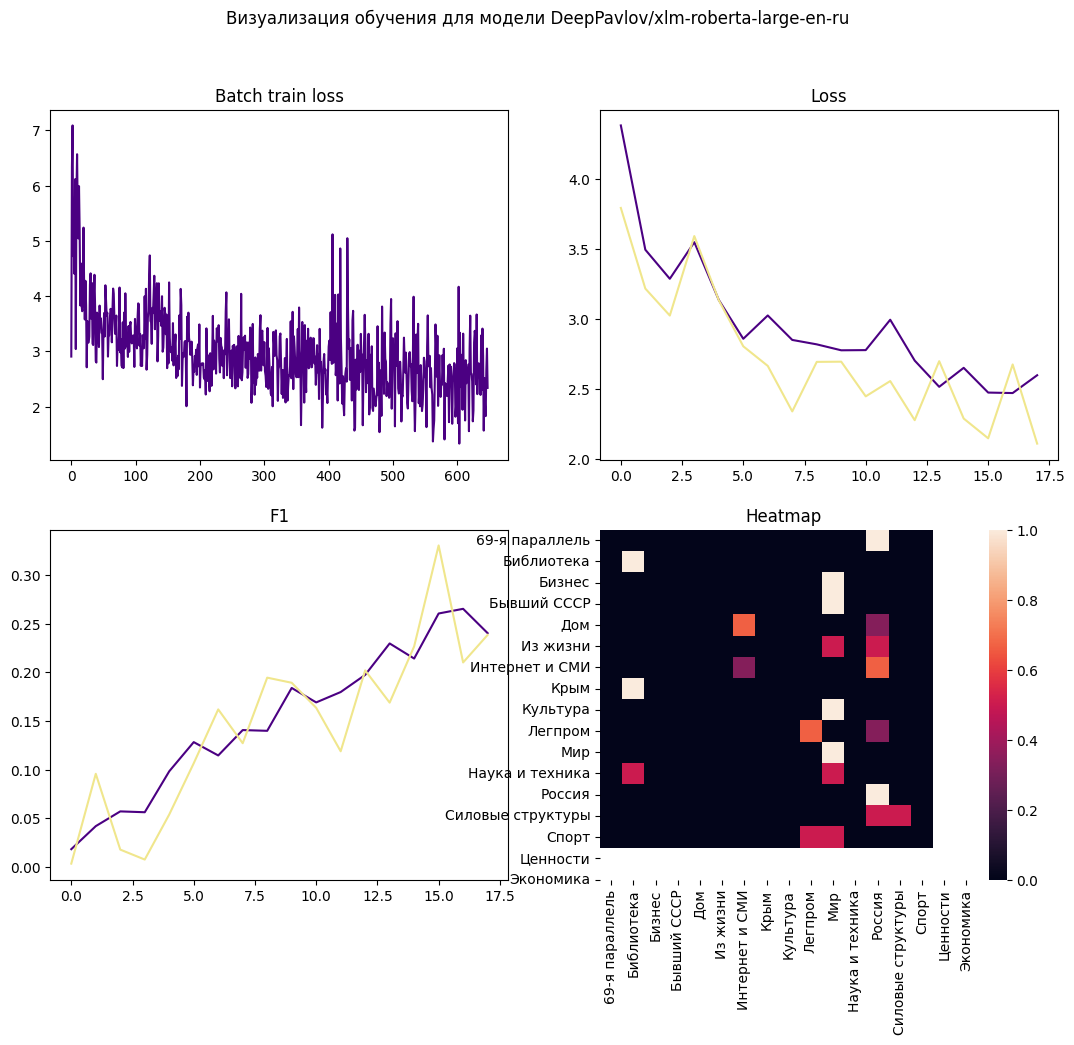

In [87]:
stat_plots(model_names[0], *learning_storage[model_names[0]])

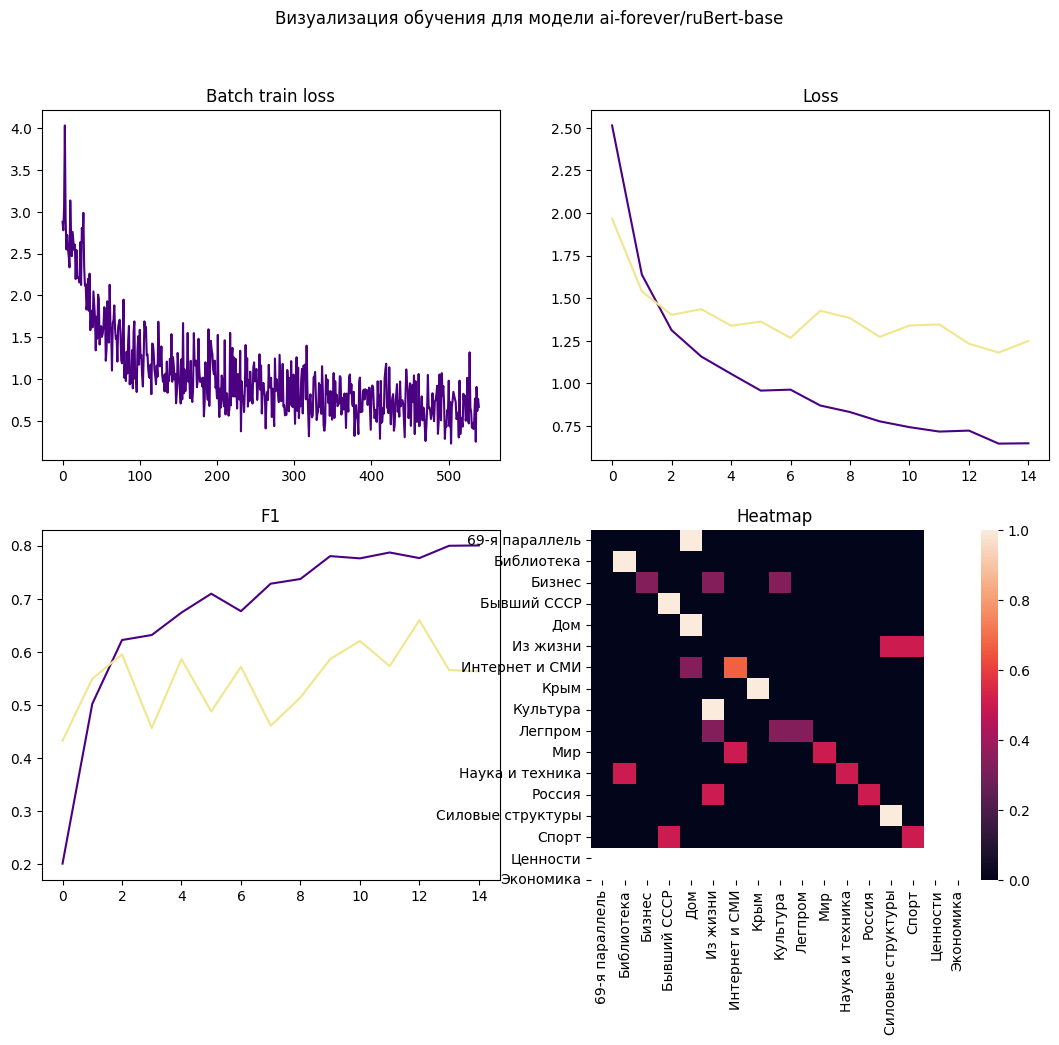

In [88]:
stat_plots(model_names[1], *learning_storage[model_names[1]])

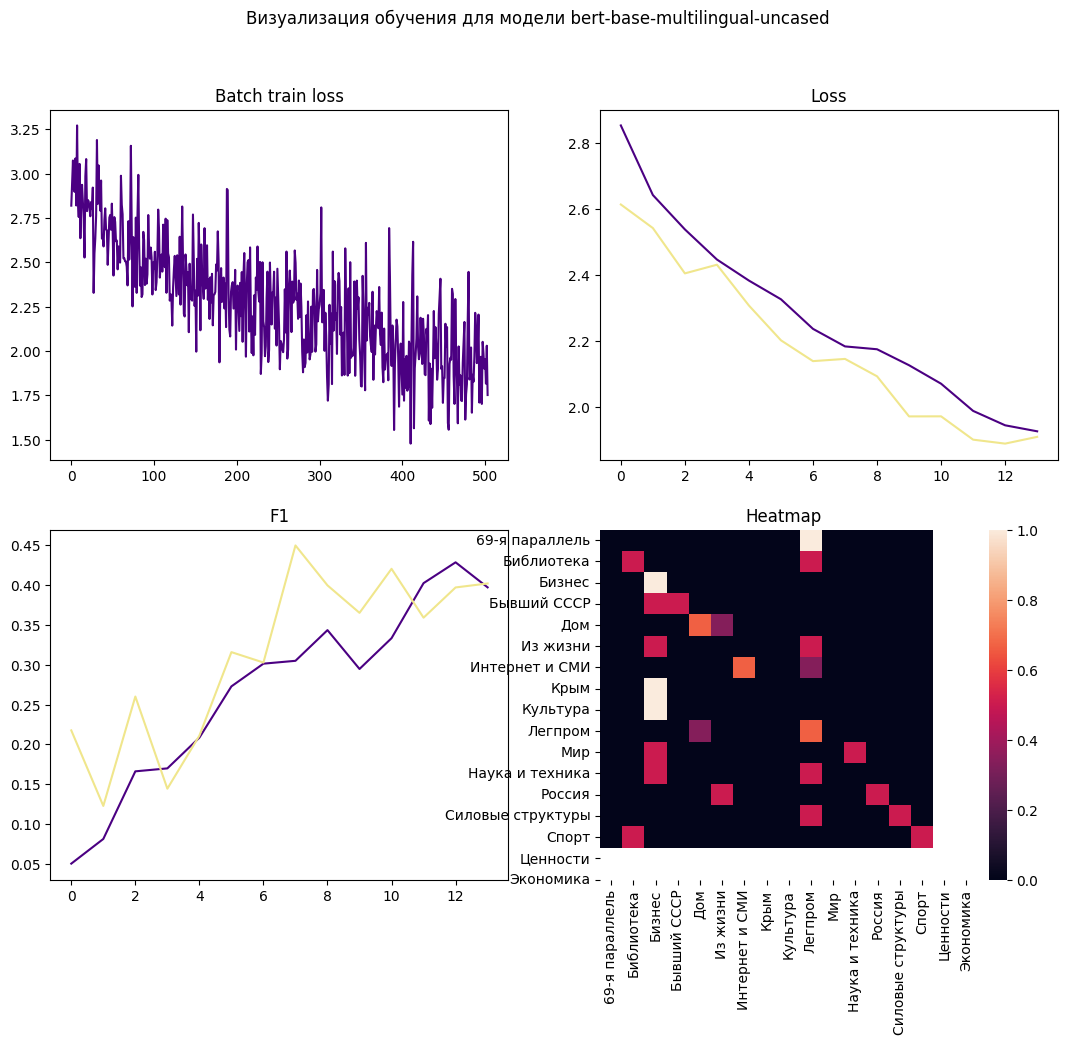

In [89]:
stat_plots(model_names[2], *learning_storage[model_names[2]])

**Вывод:**

лучше всего себя показала модель от Сбера (ее качество на тестовой выборке около 0.5 по ф-мере), далее идёт мультилингвальный берт, затем модель от ДипПавлов.
Впрочем кажется, что модель от Сбера скорее переобучается и далее не станет лучше, а у других моделей есть потенциал.

Объективно, моделька от Сбера и должна была справиться лучше, поскольку она монолингвальна.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем RoBERTa отличается от BERT? В какой статье описана RoBERTa?

RoBERTa основывается на архитектуре BERT, отличаясь от неё а) количеством данных для обучения (их больше), б) динамическим маскированием, что значит, что наши маскированные слова во время обучения меняются. Эти отличия позволили RoBERTе превзойти BERT в перфомансе (около 2 %, как сказано в оригинальной статье).

Статья:

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., ... & Stoyanov, V. (2019). <a href="https://arxiv.org/pdf/1907.11692.pdf">RoBERTa: A robustly optimized bert pretraining approach.</a> *arXiv preprint arXiv:1907.11692.*

2) Чем модель T5 отличается от ROBERTA/BERT?

T5 в отличие BERT может предсказывать не один, а сразу несколько токенов. Способна решать различные задачи благодаря текстовым инструкциям.